<Axes: xlabel='DATETIMEDATA'>

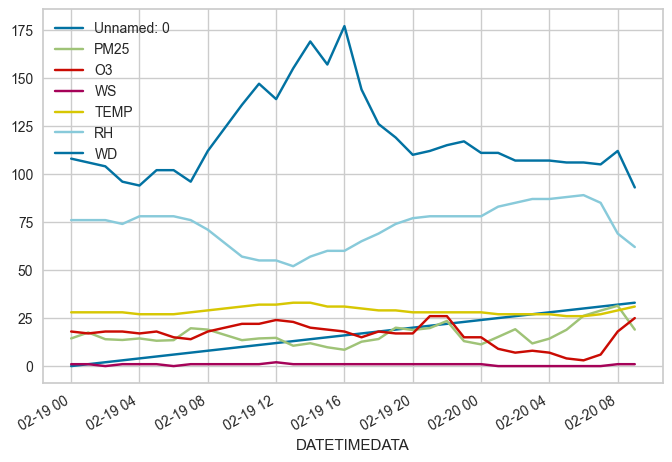

In [11]:
import pandas as pd
data = pd.read_csv('Clean_data.csv')
data["DATETIMEDATA"] = pd.to_datetime(data["DATETIMEDATA"])
data.set_index('DATETIMEDATA', inplace=True)
data.head()
data.plot()

In [12]:
data['MA12'] = data['PM25'].rolling(12).mean()

import plotly.express as px
fig = px.line(data.reset_index(), x='DATETIMEDATA', y=['PM25', 'MA12'], template='plotly_dark')
fig.show()
print(data.head())


                     Unnamed: 0  PM25    O3  WS  TEMP  RH   WD  MA12
DATETIMEDATA                                                        
2024-02-19 00:00:00           0  14.4  18.0   1    28  76  108   NaN
2024-02-19 01:00:00           1  17.5  17.0   1    28  76  106   NaN
2024-02-19 02:00:00           2  14.0  18.0   0    28  76  104   NaN
2024-02-19 03:00:00           3  13.6  18.0   1    28  74   96   NaN
2024-02-19 04:00:00           4  14.4  17.0   1    27  78   94   NaN


In [16]:
train = data[data.index < '2024-02-20 00:00:00']
test = data[data.index >= '2024-02-20 00:00:00']


In [8]:

from pycaret.regression import *
s = setup(data = train, test_data = test, target = 'PM25',  fold = 3, transform_target = True, session_id = 123)


NameError: name 'train' is not defined

In [13]:
from pycaret.regression import *
clf = setup(data, target = 'PM25')

,Description,Value
0,Session id,1113
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(33, 8)"
4,Transformed data shape,"(33, 8)"
5,Transformed train set shape,"(23, 8)"
6,Transformed test set shape,"(10, 8)"
7,Numeric features,7
8,Rows with missing values,33.3%
9,Preprocess,True


In [15]:
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,2.5943,9.0777,2.8006,-0.9074,0.1757,0.1804,0.0060
et,Extra Trees Regressor,2.3602,7.5887,2.6774,-1.2042,0.1595,0.1528,0.0150
omp,Orthogonal Matching Pursuit,2.6840,10.0575,2.9868,-1.6357,0.1798,0.1813,0.0050
llar,Lasso Least Angle Regression,2.6486,10.0438,2.9378,-1.8051,0.1768,0.1771,0.0040
lasso,Lasso Regression,2.6488,10.0444,2.9381,-1.8052,0.1768,0.1771,0.1440
en,Elastic Net,2.6384,10.0330,2.9308,-1.8249,0.1773,0.1769,0.0050
rf,Random Forest Regressor,2.5637,9.2446,2.9527,-1.8357,0.1831,0.1731,0.0160
br,Bayesian Ridge,2.8323,10.6944,3.1274,-1.8812,0.1909,0.1943,0.0040
dummy,Dummy Regressor,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0040
lightgbm,Light Gradient Boosting Machine,3.0472,13.5691,3.5696,-1.9824,0.2238,0.2172,0.0070


In [17]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2248,2.0525,1.4327,0.9036,0.0867,0.0859
1,3.4152,17.2758,4.1564,0.1549,0.2140,0.1882
2,3.6115,14.1768,3.7652,-0.9083,0.2117,0.2024
3,2.5086,10.6948,3.2703,-0.2289,0.1762,0.1297
4,2.1217,4.5036,2.1222,0.0695,0.1312,0.1297
5,10.5053,118.5002,10.8858,-25.8708,0.9177,0.6137
6,4.3524,22.0299,4.6936,-33.4218,0.2802,0.3158
7,1.9807,4.2226,2.0549,0.7151,0.1362,0.1454
8,4.5800,27.4843,5.2425,-10.4399,0.3350,0.3860


In [18]:
tuned_lr = tune_model(lr)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7107,0.5192,0.7205,0.9756,0.0497,0.0531
1,3.5229,17.4165,4.1733,0.1480,0.2136,0.1931
2,3.7322,14.9333,3.8644,-1.0102,0.2180,0.2102
3,2.4746,11.7777,3.4319,-0.3534,0.1858,0.1247
4,1.8582,3.5248,1.8774,0.2717,0.1113,0.1118
5,8.0375,67.5483,8.2188,-14.3171,0.5997,0.4730
6,2.6320,7.5576,2.7491,-10.8088,0.1755,0.1922
7,2.2677,5.6864,2.3846,0.6164,0.1565,0.1639
8,4.8768,28.4251,5.3315,-10.8315,0.3398,0.4056


Fitting 10 folds for each of 2 candidates, totalling 20 fits


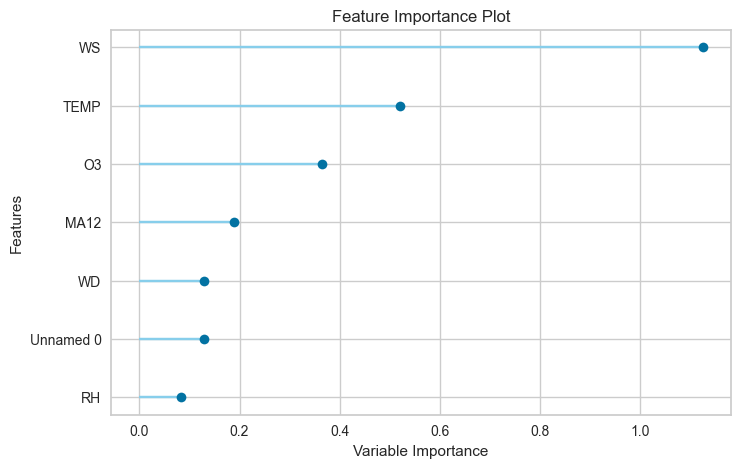

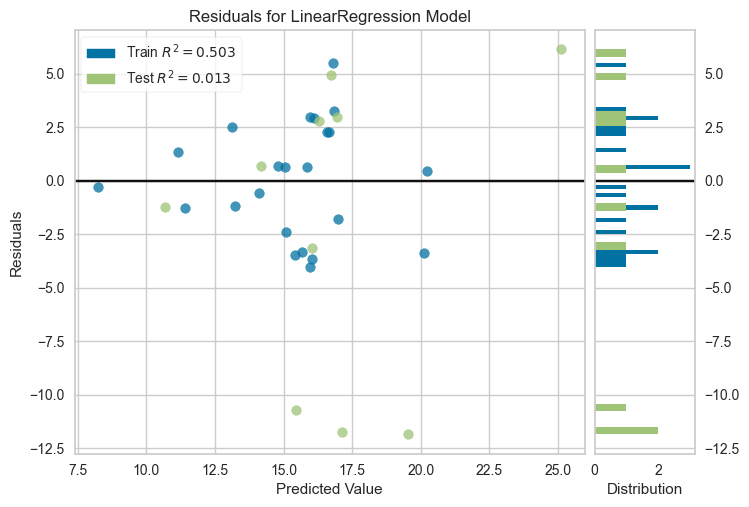

In [20]:
plot_model(tuned_lr, plot='feature')
plot_model(tuned_lr, plot='residuals')

In [23]:
prediction_data = data.drop('PM25', axis=1).copy()
predictions = predict_model(tuned_lr, data=prediction_data)
print(predictions.columns)
print(predictions[['prediction_label']])

Index(['Unnamed: 0', 'O3', 'WS', 'TEMP', 'RH', 'WD', 'MA12',
       'prediction_label'],
      dtype='object')
                     prediction_label
DATETIMEDATA                         
2024-02-19 00:00:00         15.055487
2024-02-19 01:00:00         15.078793
2024-02-19 02:00:00         16.957526
2024-02-19 03:00:00         16.833464
2024-02-19 04:00:00         16.667894
2024-02-19 05:00:00         16.124510
2024-02-19 06:00:00         16.283319
2024-02-19 07:00:00         16.054637
2024-02-19 08:00:00         15.675207
2024-02-19 10:00:00         14.162352
2024-02-19 11:00:00         13.219139
2024-02-19 12:00:00         14.101662
2024-02-19 13:00:00         13.127090
2024-02-19 14:00:00         10.670140
2024-02-19 15:00:00         11.132382
2024-02-19 16:00:00          8.221655
2024-02-19 17:00:00         11.402229
2024-02-19 18:00:00         14.786567
2024-02-19 19:00:00         15.975026
2024-02-19 20:00:00         16.985454
2024-02-19 21:00:00         20.236730
2024-02-19 22:0

In [37]:
predictions = predict_model(tuned_lr, data=prediction_data)
print(predictions)


                     Unnamed: 0    O3  WS  TEMP  RH   WD       MA12  \
DATETIMEDATA                                                          
2024-02-19 00:00:00           0  18.0   1    28  76  108        NaN   
2024-02-19 01:00:00           1  17.0   1    28  76  106        NaN   
2024-02-19 02:00:00           2  18.0   0    28  76  104        NaN   
2024-02-19 03:00:00           3  18.0   1    28  74   96        NaN   
2024-02-19 04:00:00           4  17.0   1    27  78   94        NaN   
2024-02-19 05:00:00           5  18.0   1    27  78  102        NaN   
2024-02-19 06:00:00           6  15.0   0    27  78  102        NaN   
2024-02-19 07:00:00           7  14.0   1    28  76   96        NaN   
2024-02-19 08:00:00           8  18.0   1    29  71  112        NaN   
2024-02-19 10:00:00          10  22.0   1    31  57  136        NaN   
2024-02-19 11:00:00          11  22.0   1    32  55  147        NaN   
2024-02-19 12:00:00          12  24.0   2    32  55  139  15.158334   
2024-0

In [41]:

next_5_hours = pd.DataFrame(index=pd.date_range(start=prediction_data.index[-1], periods=90, freq='H')[1:])
next_5_hours = next_5_hours.reindex(columns=prediction_data.columns)
future_predictions = predict_model(tuned_lr, data=next_5_hours)
print(future_predictions.iloc[:, -1].rename('PM25'))



2024-02-20 10:00:00    15.280985
2024-02-20 11:00:00    15.280985
2024-02-20 12:00:00    15.280985
2024-02-20 13:00:00    15.280985
2024-02-20 14:00:00    15.280985
                         ...    
2024-02-23 22:00:00    15.280985
2024-02-23 23:00:00    15.280985
2024-02-24 00:00:00    15.280985
2024-02-24 01:00:00    15.280985
2024-02-24 02:00:00    15.280985
Freq: H, Name: PM25, Length: 89, dtype: float64


In [46]:
# ตัดคอลัมน์ PM25 ออกจากข้อมูลที่ใช้ทำนาย
prediction_data = data.drop('PM25', axis=1).copy()

# สร้างข้อมูลสำหรับ 10 ชั่วโมงถัดไป
next_10_hours = prediction_data.iloc[-1].copy()
next_10_hours.name += pd.Timedelta(hours=1)  # เพิ่มชั่วโมงให้กับชื่อของแถว
next_10_hours['MA12'] = data['MA12'].iloc[-12:].mean()  # คำนวณค่าเฉลี่ยของ 12 ชั่วโมงล่าสุด

# ทำนาย PM25 ในอีก 10 ชั่วโมง
future_predictions = predict_model(tuned_lr, data=next_10_hours.to_frame().T)

# แสดงผลลัพธ์
print(future_predictions)


                     Unnamed: 0    O3   WS  TEMP    RH    WD       MA12  \
2024-02-20 10:00:00        33.0  25.0  1.0  31.0  62.0  93.0  16.495138   

                     prediction_label  
2024-02-20 10:00:00         24.581278  
